In [1]:
import numpy as np 
import scanpy as sc 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

/ihome/djishnu/alw399/.local/lib/python3.9/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/snrna_human_tonsil.h5ad')
adata

AnnData object with n_obs × n_vars = 5778 × 3333
    obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'banksy_celltypes', 'cell_type_2'
    uns: 'cell_thresholds', 'cell_type_int_colors', 'received_ligands', 'received_ligands_tfl'
    obsm: 'spatial', 'spatial_unscaled'
    layers: 'imputed_count', 'normalized_count'

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline


2025-07-01 21:23:20.486803: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-01 21:23:20.584198: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /ihome/crc/install/gcc-12.2.0/postgresql/15.2/lib:/ihome/crc/install/gcc-12.2.0/imagemagick/6.9.12/lib:/ihome/crc/install/gcc-12.2.0/geos/3.9.4/lib:/ihome/crc/install/gcc-12.2.0/zstd/zstd-1.5.5/lib:/ihome/crc/install/gcc-12.2.0/unixodbc/2.3.11/lib:/ihome/crc/install/sodium/1.0.18/lib:/ihome/crc/install/gcc-12.2.0/r/4.4.0/lib64/R/lib:/ihome/crc/install/gcc-12.2.0/open

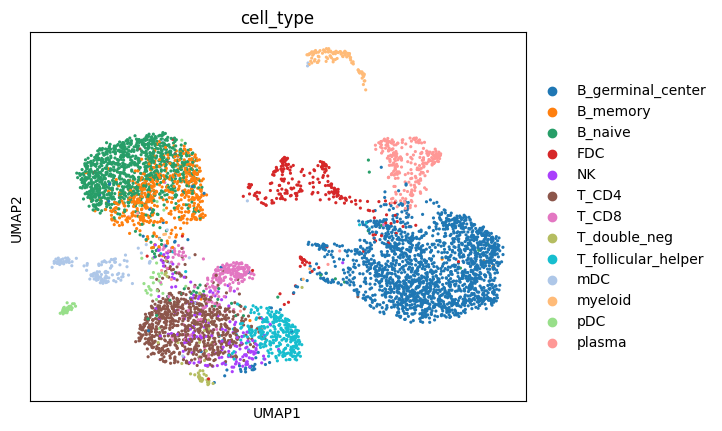

In [4]:
sc.tl.pca(adata)
sc.pp.neighbors(adata, use_rep='X_pca')
sc.tl.umap(adata)
sc.pl.umap(adata, color='cell_type')

In [5]:
color_dict = {
    'Naive CD4 T': "#ea7465",
    'T_follicular_helper': "#b74329", 
    'T memory': "#98907f",
    'T_CD8': "#6885d0",
    'Treg': "#bc8d3d",
    'Th1': "#b75fb3",
    'Th2': "#69a75b",
    'T_double_neg': "#cc5658"
}

import sys 
sys.path.append('../../src')
from spaceoracle.plotting.cartography import Cartography


In [6]:
adata.obs.head(3)

,cell_type,author_cell_type,cell_type_int,banksy_celltypes,cell_type_2
NAME,,,,,
AAACCCAAGCGCCTTG-1,T_CD4,T_CD4,5,T_CD4,Th1
AAACCCAAGTGGACGT-1,plasma,plasma,12,plasma,plasma
AAACCCACAGAAGTGC-1,B_germinal_center,B_germinal_center,0,GC Light Zone,GC Light Zone


In [7]:
adata.obs['author_cell_type'].value_counts()

author_cell_type
B_germinal_center      1848
B_naive                1067
T_CD4                   779
B_memory                516
T_follicular_helper     294
plasma                  262
FDC                     255
T_CD8                   238
NK                      170
mDC                     137
myeloid                 102
pDC                      64
T_double_neg             46
Name: count, dtype: int64

In [8]:
t_cells = [
    'T_follicular_helper', 
    'T_CD4'
]
adata_ = adata[adata.obs['cell_type'].isin(t_cells)]
adata_

View of AnnData object with n_obs × n_vars = 1073 × 3333
    obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'banksy_celltypes', 'cell_type_2'
    uns: 'cell_thresholds', 'cell_type_int_colors', 'received_ligands', 'received_ligands_tfl', 'pca', 'neighbors', 'umap', 'cell_type_colors'
    obsm: 'spatial', 'spatial_unscaled', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count'
    obsp: 'distances', 'connectivities'

In [9]:
chart = Cartography(adata_, color_dict)

In [10]:
chart.adata.obs['cell_type'].value_counts()

cell_type
T_CD4                  779
T_follicular_helper    294
Name: count, dtype: int64

In [11]:
# simulated_df = pd.read_parquet(f'/ix3/djishnu/alw399/SpaceOracle/notebooks/human_tonsil/IL21_KO_T_follicular_helper.parquet').loc[adata_.obs.index]
simulated_df = pd.read_parquet(f'/ix/djishnu/shared/djishnu_kor11/genome_screens/human_tonsil/FOXO1_4n_0x_CD4_Tfh.parquet').loc[adata_.obs.index]

method = 'ST'

In [12]:
delta_X = (simulated_df - chart.unperturbed_expression).values
gene_mtx = chart.unperturbed_expression.values
gene_mtx.shape, delta_X.shape

((1073, 3333), (1073, 3333))

In [13]:
embedding = adata_.obsm['X_umap']
P = chart.compute_transition_probabilities(delta_X, embedding, n_neighbors=800)
P.shape

(1073, 1073)

In [14]:
import alphashape
from matplotlib.legend_handler import HandlerTuple
import matplotlib
import seaborn as sns 
from shapely.geometry import Point

In [15]:
# chart.adata.obs['banksy_celltypes'].unique()

In [16]:
chart.get_transition_annot(
    P, 
    allowed_fates=chart.adata.obs['cell_type'].unique(), 
    thresh=0, 
    annot='cell_type'
)

  0%|          | 0/779 [00:00<?, ?it/s]

100%|██████████| 779/779 [00:09<00:00, 80.10it/s] 


source ct T_CD4 Counter({'T_CD4': 628, 'T_follicular_helper': 151}) 0.0002767885559133587 4.0354682100541035e-05


100%|██████████| 294/294 [00:02<00:00, 111.21it/s]

source ct T_follicular_helper Counter({'T_follicular_helper': 294}) 0.0007124455106070188 0.00028262091010964447


In [17]:
xy = pd.DataFrame(adata.obsm['spatial'], index=adata.obs.index, columns=['x', 'y'])

In [18]:
adata.obs['x'] = adata.obsm['spatial'][:, 0]
adata.obs['y'] = adata.obsm['spatial'][:, 1]

In [19]:
ct_points_wt, ct_points_ko = chart.make_celltype_dict(annot='cell_type')

In [50]:
alpha_shapes = {}

for cluster, points in ct_points_wt.items():
    alpha_shapes[cluster] = alphashape.alphashape(points, alpha=0.035)

In [51]:
import json

with open('/ix3/djishnu/alw399/SpaceOracle/manuscript/human_tonsil_slidetags/colors.json', 'r') as f:
    color_dict = json.load(f)


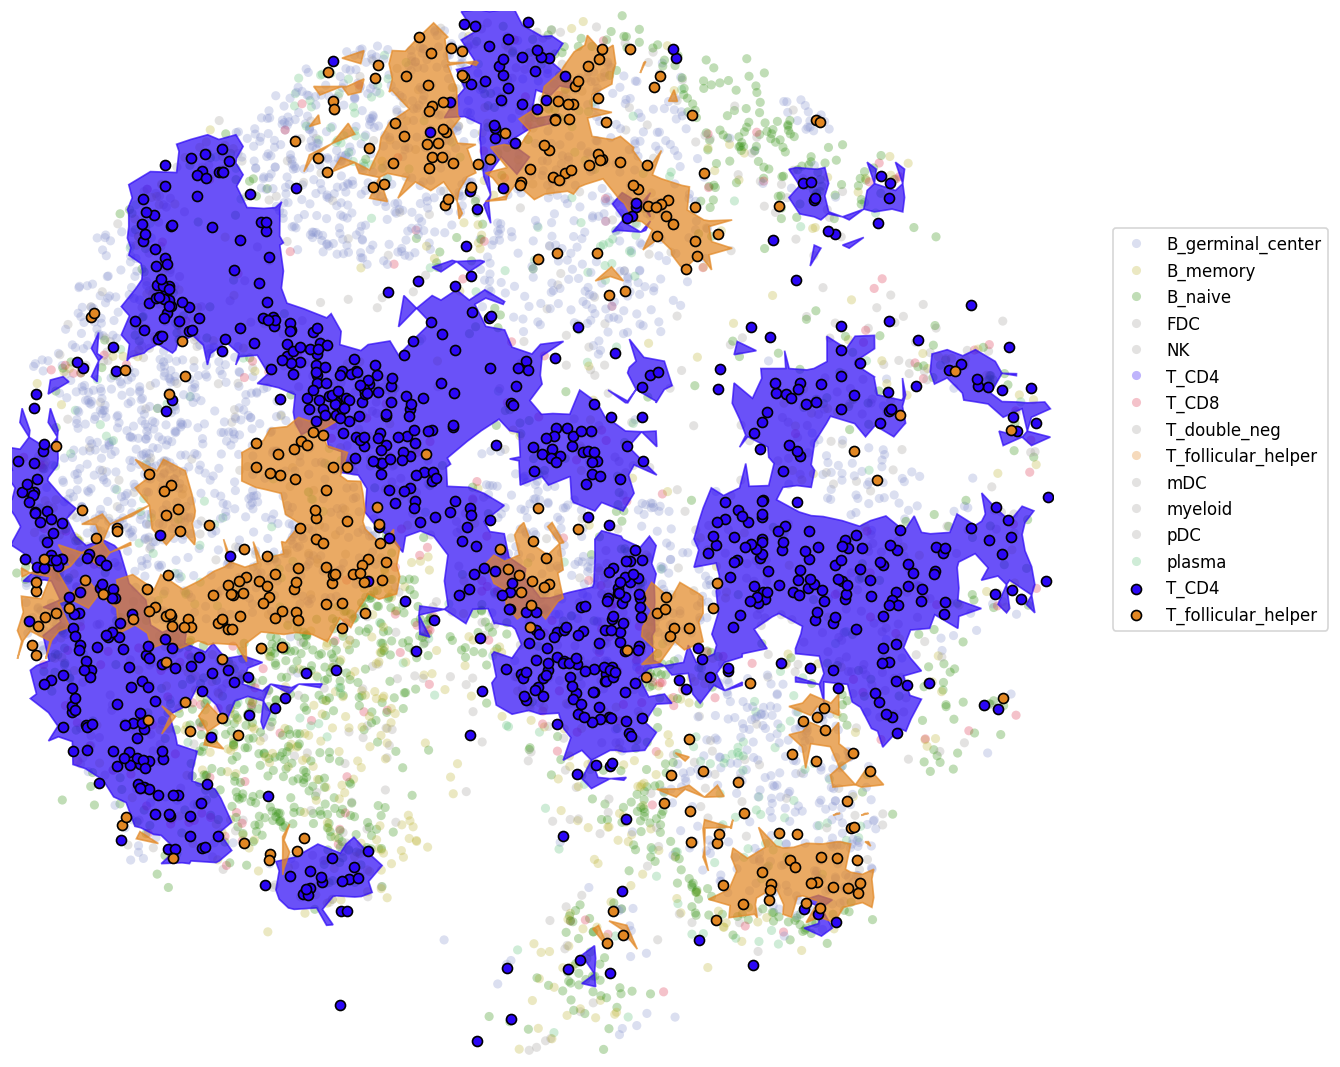

In [52]:
fig, ax = plt.subplots(figsize=(20, 9), dpi=120)

scatter = sns.scatterplot(
    data = adata.obs,
    x='x', y='y',
    hue='cell_type',
    palette=color_dict,
    s=30,
    alpha=0.3,
    edgecolor='none',
    ax=ax,
)

zone_alpha = 0.7
area_thresh = 0

for cluster, alpha_shape in alpha_shapes.items():
    try:
        for geom in alpha_shape.geoms:
            if geom.area > area_thresh:
                ax.fill(
                    geom.exterior.xy[0], 
                    geom.exterior.xy[1], 
                    color=color_dict[str(cluster)], alpha=zone_alpha)
    except:
        geom = alpha_shape
        ax.fill(
            geom.exterior.xy[0], 
            geom.exterior.xy[1], 
            color=color_dict[str(cluster)], alpha=zone_alpha
        )

for ct in chart.adata.obs['cell_type'].unique():
    ax.scatter(
        adata[adata.obs['cell_type'] == ct].obsm['spatial'][:, 0],
        adata[adata.obs['cell_type'] == ct].obsm['spatial'][:, 1],
        c=color_dict[ct], alpha=1, edgecolor='black', linewidth=1,
        label=ct
    )

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, bbox_to_anchor=(1.05, 0.8), loc='upper left')


ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_aspect('equal')
ax.set_xlim(adata.obs.x.min() - 10, adata.obs.x.max() + 10)
ax.set_ylim(adata.obs.y.min() - 10, adata.obs.y.max() + 10)
plt.tight_layout()

plt.savefig(f'figures/human_tonsil_FOXO1_KO_preKO_Tfh.svg', format='svg', bbox_inches='tight', dpi=300)

In [53]:
alpha_shapes = {}

for cluster, points in ct_points_ko.items():
    alpha_shapes[cluster] = alphashape.alphashape(points, alpha=0.035)

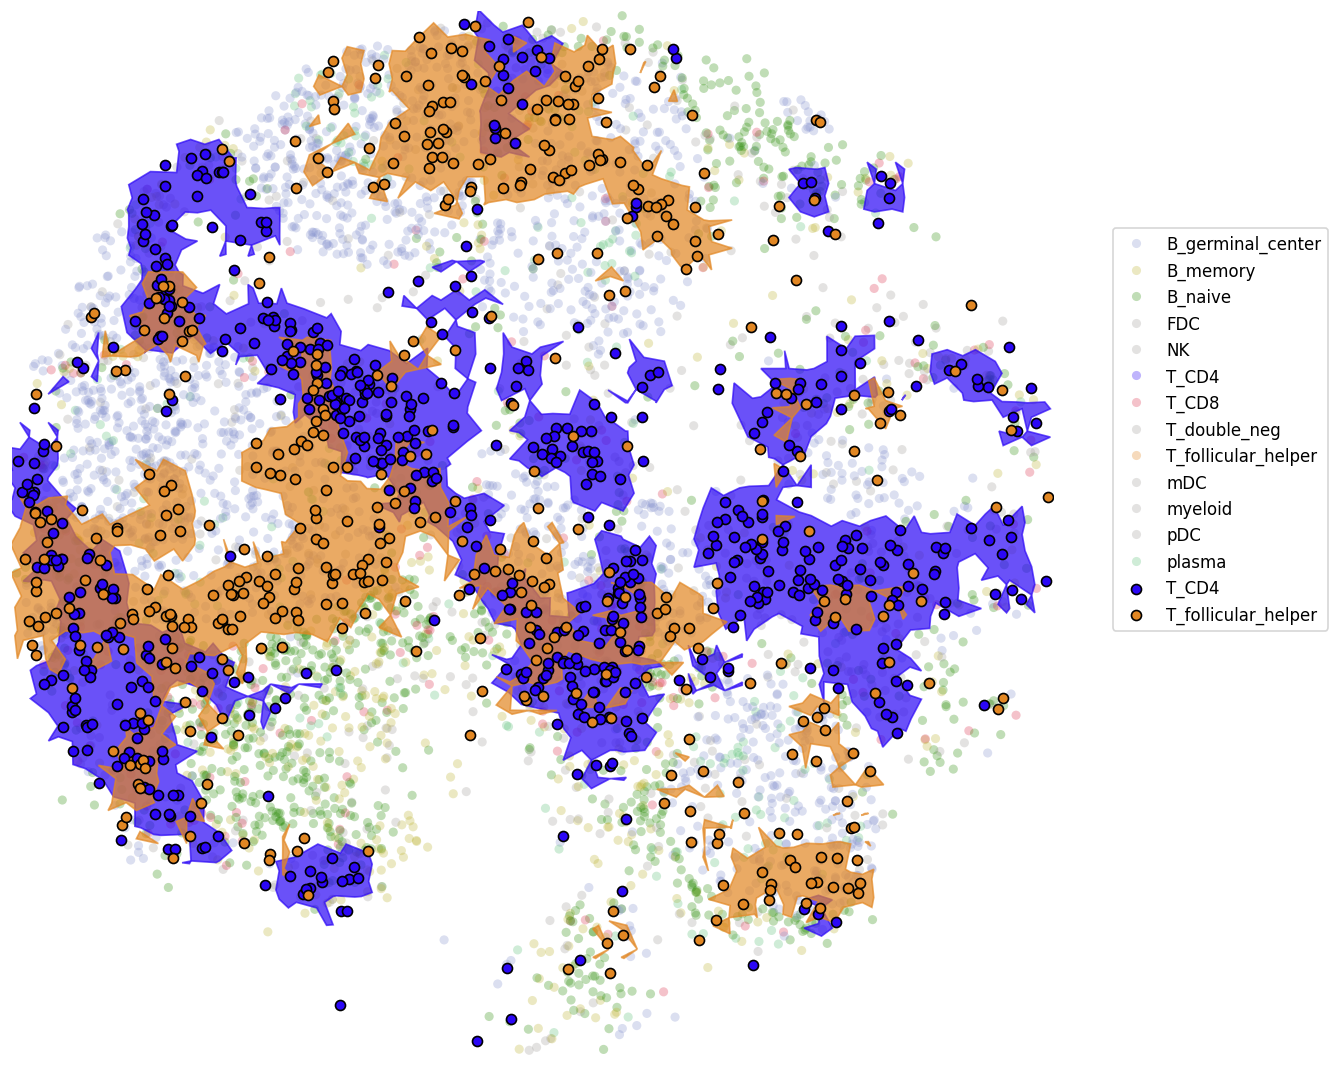

In [54]:
fig, ax = plt.subplots(figsize=(20, 9), dpi=120)

scatter = sns.scatterplot(
    data = adata.obs,
    x='x', y='y',
    hue='cell_type',
    palette=color_dict,
    s=30,
    alpha=0.3,
    edgecolor='none',
    ax=ax,
)

zone_alpha = 0.7
area_thresh = 0

for cluster, alpha_shape in alpha_shapes.items():
    try:
        for geom in alpha_shape.geoms:
            if geom.area > area_thresh:
                ax.fill(
                    geom.exterior.xy[0], 
                    geom.exterior.xy[1], 
                    color=color_dict[str(cluster)], alpha=zone_alpha)
    except:
        geom = alpha_shape
        ax.fill(
            geom.exterior.xy[0], 
            geom.exterior.xy[1], 
            color=color_dict[str(cluster)], alpha=zone_alpha
        )

for ct in chart.adata.obs['transition'].unique():
    ax.scatter(
        chart.adata[chart.adata.obs['transition'] == ct].obsm['spatial'][:, 0],
        chart.adata[chart.adata.obs['transition'] == ct].obsm['spatial'][:, 1],
        c=color_dict[ct], alpha=1, edgecolor='black', linewidth=1,
        label=ct
    )

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, bbox_to_anchor=(1.05, 0.8), loc='upper left')


ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_aspect('equal')
ax.set_xlim(adata.obs.x.min() - 10, adata.obs.x.max() + 10)
ax.set_ylim(adata.obs.y.min() - 10, adata.obs.y.max() + 10)
plt.tight_layout()

plt.savefig(f'figures/human_tonsil_FOXO1_KO_postKO_Tfh.svg', format='svg', bbox_inches='tight', dpi=300)

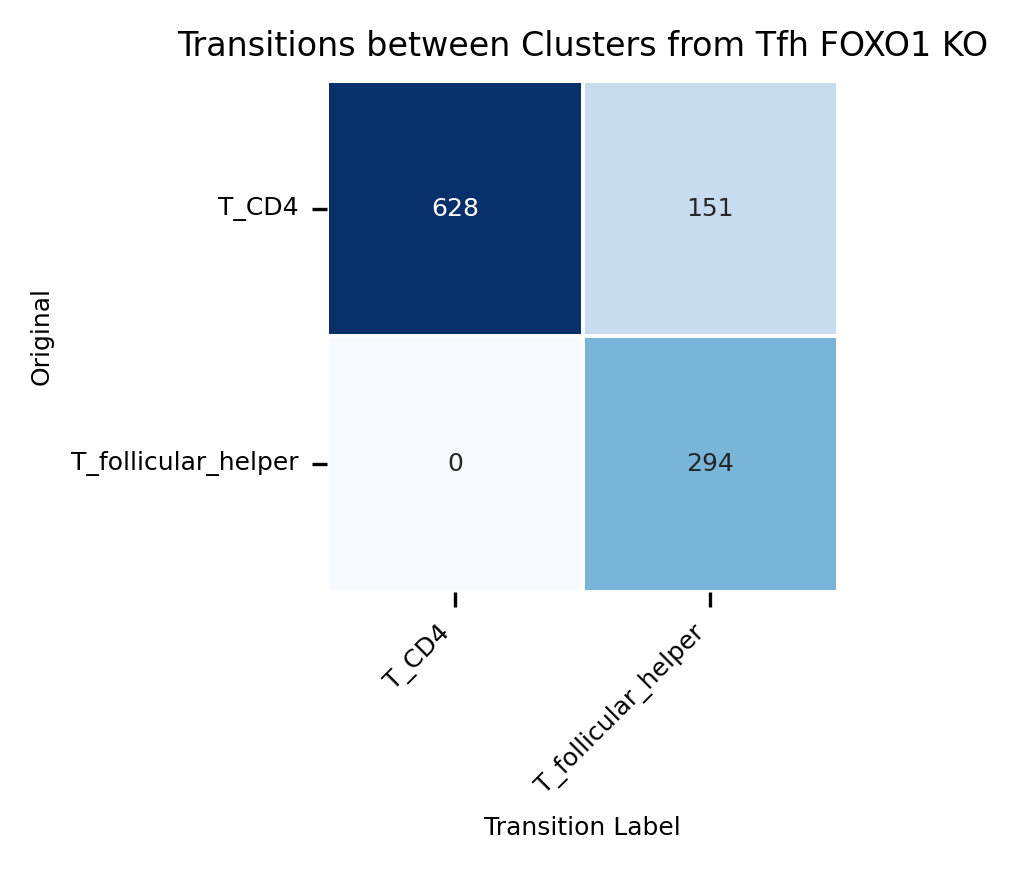

In [ ]:
chart.adata.obs['cell_type'] = chart.adata.obs['cell_type'].cat.remove_unused_categories()
chart.adata.obs['transition'] = chart.adata.obs['transition'].astype('category')
chart.adata.obs['transition']=chart.adata.obs['transition'].cat.remove_unused_categories()

df = chart.adata.obs[['cell_type', 'transition']].copy()
counts = df.groupby(['cell_type', 'transition']).size().unstack(fill_value=0)

plt.figure(figsize=(3,3), dpi=300)

# Ensure counts has same number of rows and columns
if counts.empty:
    # Create empty DataFrame with same index and columns
    counts = pd.DataFrame(0, index=counts.index, columns=counts.columns)
elif len(counts.index) != len(counts.columns):
    # Add missing rows/columns with zeros
    all_labels = sorted(set(counts.index) | set(counts.columns))
    counts = counts.reindex(index=all_labels, columns=all_labels, fill_value=0)

sns.heatmap(
    counts,
    annot=True,
    fmt='d',  # Changed to integer format
    cmap='Blues',
    linewidths=0.5,
    linecolor='white',
    cbar=False,
    square=True,
    annot_kws={"size": 6}
)
plt.title(f"Transitions between Clusters from Tfh FOXO1 KO", fontsize=8)
plt.xlabel("Transition Label", fontsize=6)
plt.ylabel("Original", fontsize=6)
plt.xticks(rotation=45, ha='right', fontsize=6)
plt.yticks(rotation=0, fontsize=6)

plt.tight_layout()
plt.savefig(f'figures/human_tonsil_FOXO1_KO_transitions_Tfh.svg', 
            format='svg', transparent=True, dpi=300, bbox_inches='tight')
plt.show()